INCLUDE lr_code? Late running reason?
TODO: Include weather (mebbe)
-OHE the hours - maybe divide into 2 or 3 hour blocks for simplicity.
-Functionalise the entire thing and auto OHE THE INPUTS
-do GB AS WELL

In [1]:
#!pip install tensorflow


#params:

knn = True
gb = False
mlp = False

In [2]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import os

# Designate the directory path where you saved your CSV files
data_dir = "data/"

# List all CSV files in the directory
csv_files = [file for file in os.listdir(data_dir) if file.endswith(".csv")]

# Initialize an empty list to store DataFrames
dfs = []

# Iterate over each CSV file, load it, and append it to the list of DataFrames
for csv_file in csv_files:
    file_path = os.path.join(data_dir, csv_file)
    df = pd.read_csv(file_path)
    dfs.append(df)

# Concatenate all DataFrames into one large DataFrame
X = pd.concat(dfs, ignore_index=True)
#extract the target column.
#y = orig_data["target"] 

cols = ['tpl','pta','arr_at']


X.rename(columns={'pta': 'PLANNED_ARRIVAL'}, inplace=True)
X.rename(columns={'arr_at': 'ACTUAL_ARRIVAL'}, inplace=True)
X.rename(columns={'tpl': 'STATION'}, inplace=True)
X.rename(columns={'ptd': 'PLANNED_DEPART'}, inplace=True)
X.rename(columns={'dep_at': 'ACTUAL_DEPART'}, inplace=True)
cols = ['rid','STATION','PLANNED_ARRIVAL','ACTUAL_ARRIVAL',"PLANNED_DEPART", "ACTUAL_DEPART"]

X_ESSENTIAL = X[cols]

Each rid corresponds to 1 journey

In [3]:
cols_to_delete = ['PLANNED_ARRIVAL','ACTUAL_ARRIVAL',"PLANNED_DEPART", "ACTUAL_DEPART"]
stations_keep =['LIVST','STFD','SHENFLD','CHLMSFD','CLCHSTR','MANNGTR','IPSWICH','STWMRKT','DISS','NRCH']
X_ESSENTIAL = X_ESSENTIAL[X_ESSENTIAL['STATION'].isin(stations_keep)]

Find the difference in time between actual and planned arrival:

In [4]:
from datetime import datetime

# Assuming X_ESSENTIAL is your DataFrame with the relevant columns
# Convert time strings to datetime objects for easier manipulation
X_PLANNED_ARR = pd.to_datetime(X_ESSENTIAL['PLANNED_ARRIVAL'], format='%H:%M', errors='coerce')
X_ACTUAL_ARR = pd.to_datetime(X_ESSENTIAL['ACTUAL_ARRIVAL'], format='%H:%M', errors='coerce')
# rid =201901027628976


# Calculate the time difference
print(X_ACTUAL_ARR[96:127], X_PLANNED_ARR[96:127])
X_ESSENTIAL['DIFFERENCE'] = X_ACTUAL_ARR - X_PLANNED_ARR #As type to convert to minutes

#print(X_ESSENTIAL[X_ESSENTIAL['rid']==201901027628976]['DIFFERENCE'])
# Convert time difference to seconds
X_ESSENTIAL['DIFFERENCE'] = X_ESSENTIAL['DIFFERENCE'].dt.total_seconds() / 60.0

#GPT
print(X_ESSENTIAL[X_ESSENTIAL['rid']==201901027628976]['DIFFERENCE'])
next_day_mask = (X_ACTUAL_ARR < X_PLANNED_ARR) & (X_ESSENTIAL['DIFFERENCE'] < -36000/60)
X_ESSENTIAL.loc[next_day_mask, 'DIFFERENCE'] += 24 * 60

X_ESSENTIAL['DIFFERENCE']
# Print the DataFrame to check the results
print(X_ESSENTIAL[X_ESSENTIAL['rid']==201901027628976]['DIFFERENCE'])

304   1900-01-01 17:16:00
307   1900-01-01 17:29:00
309   1900-01-01 17:43:00
313   1900-01-01 18:03:00
314                   NaT
317                   NaT
329                   NaT
330                   NaT
333   1900-01-01 17:15:00
334                   NaT
336   1900-01-01 17:40:00
339   1900-01-01 17:53:00
341   1900-01-01 18:07:00
345   1900-01-01 18:26:00
346                   NaT
349                   NaT
361                   NaT
362                   NaT
365                   NaT
366                   NaT
368   1900-01-01 18:00:00
371                   NaT
373   1900-01-01 18:22:00
377   1900-01-01 18:41:00
378                   NaT
381   1900-01-01 17:09:00
393   1900-01-01 17:23:00
394   1900-01-01 17:34:00
397   1900-01-01 18:01:00
398   1900-01-01 18:10:00
400   1900-01-01 18:22:00
Name: ACTUAL_ARRIVAL, dtype: datetime64[ns] 304   1900-01-01 17:07:00
307   1900-01-01 17:19:00
309   1900-01-01 17:31:00
313   1900-01-01 17:53:00
314                   NaT
317                 

Calculate if_weekend:

In [5]:
def is_weekend(rid):
    
    date_str = str(rid)[:8]
    date_str = datetime.strptime(date_str, '%Y%m%d')
    date_str = date_str.strftime('%Y-%m-%d')
    # Convert the date string to a datetime object
    date = datetime.strptime(date_str, '%Y-%m-%d')
    
    # Check if the day of the week is either Saturday (5) or Sunday (6)
    return date.weekday() in [5, 6]

X_ESSENTIAL['is_weekend'] = X_ESSENTIAL['rid'].apply(is_weekend)



Check off-peak --- departs after 9?

In [6]:
def is_offpeak(row):

    weekend = row['is_weekend']
    departure = row['PLANNED_DEPART']
    
    if weekend:
        return True
    else:
        if pd.isna(departure):
            return None  # If departure time is NaN, consider it as not off-peak
        #departure = input_frame['PLANNED_DEPART']
        departure = str(departure)
        time_obj = datetime.strptime(departure, '%H:%M')
        # Create a datetime object representing 09:00
        nine_am = datetime.strptime('09:00', '%H:%M')

        two_am = datetime.strptime('02:00', '%H:%M')
        if (time_obj <= two_am):
            return True
        return time_obj >= nine_am

test_cols = ['is_weekend','PLANNED_DEPART']
X_ESSENTIAL['is_offpeak'] = X_ESSENTIAL[test_cols].apply(is_offpeak, axis=1)


Now add day of week, hour of day, first station deviation from departure - For each rid, what was the first station that had a positive value for DIFFERENCE


In [7]:
def add_day(rid):
    
    date_str = str(rid)[:8]
    date_str = datetime.strptime(date_str, '%Y%m%d')
    day_of_week = date_str.strftime('%A')
    
    # Return the name of the day of the week as a string
    return day_of_week

X_ESSENTIAL['DAY'] = X_ESSENTIAL['rid'].apply(add_day)


In [8]:
def add_hour(row):


    if pd.isna(row):
        return None  # If departure time is NaN, consider it as not off-peak

    departure = str(row)
    time_obj = datetime.strptime(departure, '%H:%M')

    # Extract the hour of the day as a string
    hour_of_day = time_obj.strftime('%H')
    
    return hour_of_day


X_ESSENTIAL['HOUR'] = X_ESSENTIAL['ACTUAL_ARRIVAL'].apply(add_hour)


Now delete passing stations: Keep the main ones

In [9]:

#X_ESSENTIAL.dropna(subset=cols_to_delete, how='all', inplace=True)


Drop the arrival/dep time columns - THIS IS WHERE THE DIFFERENCE IS. ATTEMPT TO ELIMINATE ALL STATIONS THAT DON'T HAVE VALUES FOR DIFFERENCE FOR THE SELECTED STATIONS (IGNORING LIV STREET AND NORWICH)

In [10]:
def get_first_station(rid_dataframe):
    first_station = rid_dataframe['STATION'].iloc[0]
    return first_station


grouped = X_ESSENTIAL.groupby('rid')

# Dictionary to store dataframes for each unique rid
rid_dataframes = {}

# Iterate over each group and store it in the dictionary
for rid, group_df in grouped:

    rid_dataframes[rid] = group_df
    

# for rid, rid_dataframe in rid_dataframes.items():
#     first_station = get_first_station(rid_dataframe)
#     print(f"For journey {rid}, the first station is: {first_station}")
#rid_123_df = rid_dataframes[202201017036050.0]


In [11]:
#X_ESSENTIAL= X_ESSENTIAL.drop(columns=cols_to_delete)
X_ESSENTIAL.to_csv('bum.csv', index=False)


#THIS IS THE MODIFIED JOURNEY CLASS CODE. (HOPEFULLY) FINDS THE RIDS THAT HAVE ALL 10 RELEVANT STATIONS AND DISCARDS THE REST. 
#TRY IT AND SEE
class Journey:
    def __init__(self, rid, rid_dataframe):
        self.rid = rid
        self.stations = []
        self.differences = []
        self.is_weekend = []
        self.is_offpeak = []  # Additional variables specific to the journey
        self.day = []
        self.hour = []
        self.is_delete = False
        for index, row in rid_dataframe.iterrows():
            
            delete_me = False
            #iter over the values in the difference and station row

            if (row['STATION'] == 'NRCH') or (row['STATION'] == 'LIVST'):
                self.stations.append(row['STATION'])
                self.differences.append(row['DIFFERENCE'])
                self.is_weekend.append(row['is_weekend'])
                self.is_offpeak.append(row['is_offpeak'])
                self.day.append(row['DAY'])
                self.hour.append(row['HOUR'])
                pass
            elif np.isnan(row['DIFFERENCE']):
                self.is_delete = True
            else:
                self.stations.append(row['STATION'])
                self.differences.append(row['DIFFERENCE'])
                self.is_weekend.append(row['is_weekend'])
                self.is_offpeak.append(row['is_offpeak'])
                self.day.append(row['DAY'])
                self.hour.append(row['HOUR'])
            

    def __repr__(self):
        return f"Journey: {self.rid} - Stations: {self.stations}"
    
rid = 202201017036041  # Example rid
rid_dataframe = rid_dataframes[rid]

# Create a Journey object
journey = Journey(rid, rid_dataframe)
#print(journey.is_weekend)

# Create Journey objects for each unique rid in rid_dataframes
journeys = []

for rid, rid_dataframe in rid_dataframes.items():
    journey = Journey(rid, rid_dataframe)
    journeys.append(journey)

rids_to_ridof = []

for journey in journeys:
    if (journey.is_delete) or (len(journey.stations) !=10):
        rids_to_ridof.append(journey.rid)

print(len(rids_to_ridof))
rids_to_ridof.append(202002217641960)
X_ESSENTIAL_2 = X_ESSENTIAL.copy()
#X_ESSENTIAL= X_ESSENTIAL.drop(columns=cols_to_delete)
X_ESSENTIAL_2 = X_ESSENTIAL_2[~X_ESSENTIAL_2['rid'].isin(rids_to_ridof)]
X_ESSENTIAL_2.to_csv('testingafterrids.csv', index=False)


54665


In [12]:
X_ESSENTIAL= X_ESSENTIAL_2.drop(columns=cols_to_delete)
X_ESSENTIAL.to_csv('bum.csv', index=False)


fill in where there are nans because I used arrive time for the hour/offpeak calc

This code back/f fills the values such that trains schedules without all of the desired station stops are included - TRY WITHOUT DOING THIS

In [13]:
X_ESSENTIAL.loc[X_ESSENTIAL['STATION'] == 'LVST', 'DIFFERENCE'] = 0 # CHANGE ALL LIVERPOOL STREETS TO 0 DIFFERENCE
X_ESSENTIAL['HOUR'].fillna(method='bfill', inplace=True)
X_ESSENTIAL['HOUR'].fillna(method='ffill', inplace=True)
X_ESSENTIAL['is_offpeak'].fillna(method='bfill', inplace=True)
X_ESSENTIAL['is_offpeak'].fillna(method='ffill', inplace=True)
X_ESSENTIAL['DIFFERENCE'].fillna(method='ffill', inplace=True) # THIS IS BFILL - SO A TRAIN THAT IS PASSED has the same lateness 
#as the previous train
X_ESSENTIAL['DIFFERENCE'].fillna(method='bfill', inplace=True)

In [14]:
def get_stops_left(rid_dataframe, current_station):
    print(rid_dataframe)
    # Find the index of the current station
    current_station_index = rid_dataframe.index[rid_dataframe['STATION'] == current_station][0]

    # Extract subsequent stops
    stops_left = rid_dataframe.loc[current_station_index + 1:, 'STATION'].values

    return stops_left
rid = 202201017036041  
current_station = 'IPSWICH'  
rid_dataframe = rid_dataframes[rid]  

stops_left = get_stops_left(rid_dataframe, current_station)
print(f"For journey {rid}, stops left after {current_station}: {stops_left}")

                  rid  STATION PLANNED_ARRIVAL ACTUAL_ARRIVAL PLANNED_DEPART  \
1424708  2.022010e+14    LIVST             NaN            NaN          06:22   
1424711  2.022010e+14     STFD             NaN          06:29          06:29   
1424723  2.022010e+14  SHENFLD             NaN            NaN            NaN   
1424724  2.022010e+14  CHLMSFD           06:57          06:54          06:58   
1424727  2.022010e+14  CLCHSTR           07:16          07:14          07:17   
1424728  2.022010e+14  MANNGTR           07:24          07:23          07:25   
1424730  2.022010e+14  IPSWICH           07:35          07:34          07:36   
1424733  2.022010e+14  STWMRKT           07:47          07:46          07:48   
1424735  2.022010e+14     DISS           07:59          07:58          08:00   
1424739  2.022010e+14     NRCH           08:17          08:16            NaN   

        ACTUAL_DEPART  DIFFERENCE  is_weekend is_offpeak       DAY  HOUR  
1424708         06:21         NaN        Tru

In [15]:
# #DELTE THIS
# class Journey:
#     def __init__(self, rid, rid_dataframe):
#         self.rid = rid
#         self.stations = []
#         self.differences = []
#         self.is_weekend = []
#         self.is_offpeak = []  # Additional variables specific to the journey
#         self.day = []
#         self.hour = []
        
#         # Iterate over rows in the rid_dataframe to populate journey details
#         for index, row in rid_dataframe.iterrows():
#             self.stations.append(row['STATION'])
#             self.differences.append(row['DIFFERENCE'])
#             self.is_weekend.append(row['is_weekend'])
#             self.is_offpeak.append(row['is_offpeak'])
#             self.day.append(row['DAY'])
#             self.hour.append(row['HOUR'])
            

#     def __repr__(self):
#         return f"Journey: {self.rid} - Stations: {self.stations}"
    
# rid = 202201017036041  # Example rid
# rid_dataframe = rid_dataframes[rid]

# # Create a Journey object
# journey = Journey(rid, rid_dataframe)
# #print(journey.is_weekend)

# # Create Journey objects for each unique rid in rid_dataframes
# journeys = []

# for rid, rid_dataframe in rid_dataframes.items():
#     journey = Journey(rid, rid_dataframe)
#     journeys.append(journey)

# rids_to_ridof = []

# for journey in journeys:
#     if (len(journey.stations) !=10):
#         rids_to_ridof.append(journey.rid)

# print(len(rids_to_ridof))


# #X_ESSENTIAL= X_ESSENTIAL.drop(columns=cols_to_delete)
# X_ESSENTIAL = X_ESSENTIAL[~X_ESSENTIAL['rid'].isin(rids_to_ridof)]


Group hours in sensible categories then OHE in the preprocessing stage

In [16]:

# Define the ranges for grouping
ranges = [(6,9),(10, 15), (16, 19), (20, 23),(0,5)]
# Convert 'HOURS' column to integers
X_ESSENTIAL['HOUR'] = pd.to_numeric(X_ESSENTIAL['HOUR'])

# Function to group hours
def group_hours(hour):
    for i, (start, end) in enumerate(ranges):
        if start <= hour <= end:
            return f'Group_{i + 1}'
    return 'Other'
# Create a new column with grouped values
X_ESSENTIAL['HOURS_GROUP'] = X_ESSENTIAL['HOUR'].apply(group_hours)



Preprocess data

In [17]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
#X_ESSENTIAL.to_csv('test_b3_knn.csv', index=False)
# Data preprocessing
# Perform one-hot encoding for categorical variables
X_ESSENTIAL = pd.get_dummies(X_ESSENTIAL, columns=['DAY'])

# Scale numerical variables
#scaler = StandardScaler()
#X_ESSENTIAL[['HOUR']] = scaler.fit_transform(X_ESSENTIAL[['HOUR']])

X_ESSENTIAL = pd.get_dummies(X_ESSENTIAL, columns=['HOURS_GROUP'])
X_ESSENTIAL = X_ESSENTIAL.drop(columns='HOUR')

# Convert boolean columns to integers
bool_cols = ['is_weekend', 'is_offpeak']
X_ESSENTIAL[bool_cols] = X_ESSENTIAL[bool_cols].astype(int)


if 'DAY_Saturday' not in X_ESSENTIAL.columns:
    # Add the column filled with zeros
    X_ESSENTIAL['DAY_Saturday'] = 0




# Label encode 'DAY' column
#label_encoder = LabelEncoder()
#X_ESSENTIAL['DAY'] = label_encoder.fit_transform(X_ESSENTIAL['DAY'])
#X_ESSENTIAL['HOUR'] = label_encoder.fit_transform(X_ESSENTIAL['HOUR'])

In [18]:
X_ESSENTIAL.to_csv('test_b4_knn.csv', index=False)


There are some train performance information web sites that may provide an estimated or
predicted arrival time for a train at any station along its journey. You may use their estimated
time as a comparison baseline to your predictive models.

In [19]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import pickle
def plot_resids(y_test, y_pred):
    # Calculate residuals
    residuals = y_test - y_pred
    
    # Create residuals plot
    plt.figure(figsize=(8, 6))
    plt.scatter(y_pred, residuals, c='blue', alpha=0.5)
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title(f'Residuals Plot for Station {stations[i]}')
    plt.axhline(y=0, color='red', linestyle='--')
    plt.show()



# Define hyperparameter grids for grid search - THIS IS THE LONG VERSION FOR WHEN YOU HAVE TIME
param_grid_gb_LONG = {
    'classifier__n_estimators': [50, 100, 200],      # Number of boosting stages
    'classifier__learning_rate': [0.05, 0.1],    # Learning rate shrinks the contribution of each tree
    'classifier__max_depth': [3, 4],               # Maximum depth of the individual trees
    'classifier__min_samples_split': [2, 5, 10],      # Minimum number of samples required to split an internal node
    'classifier__min_samples_leaf': [1, 2, 4],        # Minimum number of samples required to be at a leaf node
}

param_grid_gb = {
    'n_estimators': [50],      # Number of boosting stages
    'learning_rate': [0.05],    # Learning rate shrinks the contribution of each tree
    'max_depth': [3],               # Maximum depth of the individual trees
    'min_samples_split': [2],      # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1],        # Minimum number of samples required to be at a leaf node
}


if gb:
    stations = X_ESSENTIAL['STATION'].unique()
    stations = stations.tolist()
    models_gb = {}

    for i in range(len(stations)-1):
        # Filter data for the current station
        station_data = X_ESSENTIAL[X_ESSENTIAL['STATION'] == stations[i]]
        next_station_data = X_ESSENTIAL[X_ESSENTIAL['STATION'] == stations[i+1]]

        # Set negative values in 'DIFFERENCE' column to 0
        #next_station_data['DIFFERENCE'] = next_station_data['DIFFERENCE'].clip(lower=0)

        # Select features and target
        X = station_data.drop(columns=['rid','STATION'])
        y = next_station_data['DIFFERENCE']

        # Split data into train and test sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Initialize Gradient Boosting classifier
        classifier_gb = GradientBoostingClassifier()

        # Perform grid search
        grid_search = GridSearchCV(classifier_gb, param_grid_gb, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
        grid_search.fit(X_train, y_train)

        # Get the best model
        best_gb = grid_search.best_estimator_

        # Evaluate the best model
        y_pred = best_gb.predict(X_test)
        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        plot_resids(y_test, y_pred)
        print(f"Metrics for station {stations[i]}:")
        print(f"Mean Absolute Error: {mae}")
        print(f"Mean Squared Error: {mse}")
        print(f"R-squared Score: {r2}")
        print("Best Parameters:", grid_search.best_params_)
        print("-------------------------------")

        # Save the trained model
        models_gb[stations[i]] = best_gb
    file_path_models_gb = 'models_gb.pickle'

KNN:

In [20]:
print(X_ESSENTIAL[X_ESSENTIAL['STATION'] == 'MANNGTR'].shape)

(886, 17)


(886, 17)
(886, 17)
(178, 15)


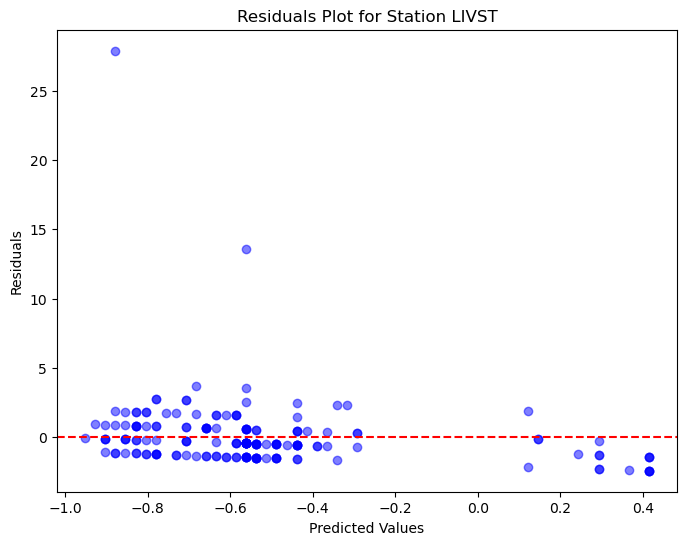

Metrics for station LIVST:
Mean Absolute Error: 1.288983283091258
Mean Squared Error: 7.043008776209988
R-squared Score: -0.04784768133807238
Best Parameters: {'algorithm': 'auto', 'leaf_size': 20, 'metric': 'manhattan', 'n_neighbors': 41, 'p': 1, 'weights': 'uniform'}
-------------------------------
{'LIVST': KNeighborsRegressor(leaf_size=20, metric='manhattan', n_neighbors=41, p=1)}
(178, 15)


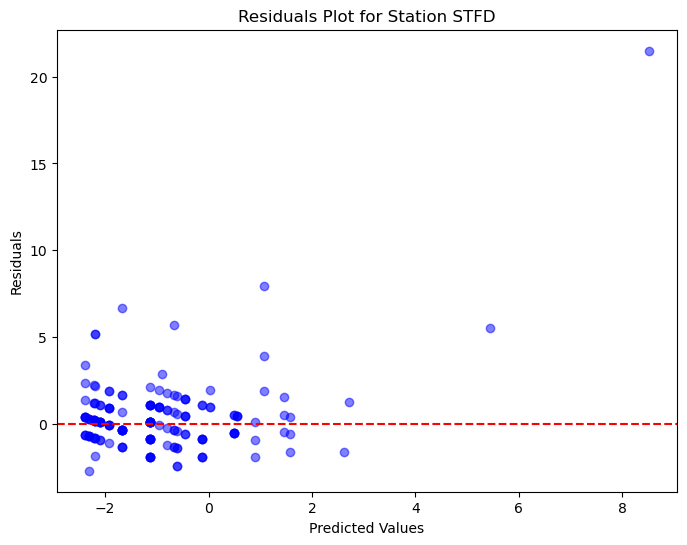

Metrics for station STFD:
Mean Absolute Error: 1.1910112359550562
Mean Squared Error: 5.123934571899589
R-squared Score: 0.4637083552972322
Best Parameters: {'algorithm': 'auto', 'leaf_size': 20, 'metric': 'euclidean', 'n_neighbors': 31, 'p': 1, 'weights': 'uniform'}
-------------------------------
{'LIVST': KNeighborsRegressor(leaf_size=20, metric='manhattan', n_neighbors=41, p=1), 'STFD': KNeighborsRegressor(leaf_size=20, metric='euclidean', n_neighbors=31, p=1)}
(178, 15)


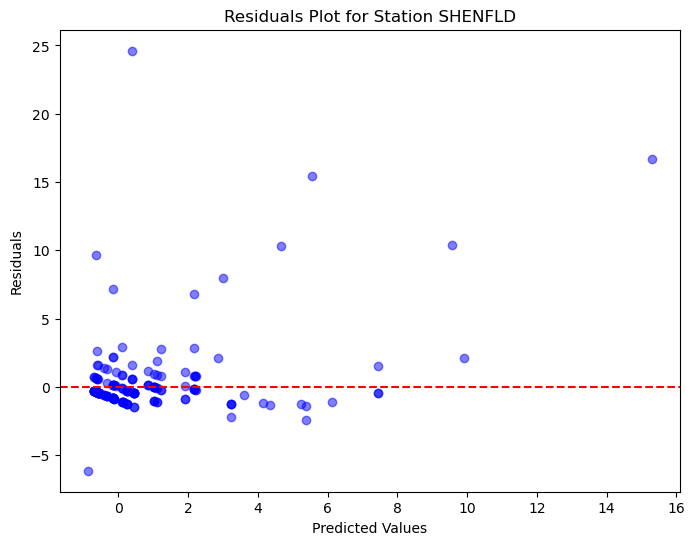

Metrics for station SHENFLD:
Mean Absolute Error: 1.3356288510329828
Mean Squared Error: 10.004022027616365
R-squared Score: 0.491224839249059
Best Parameters: {'algorithm': 'ball_tree', 'leaf_size': 10, 'metric': 'euclidean', 'n_neighbors': 31, 'p': 1, 'weights': 'uniform'}
-------------------------------
{'LIVST': KNeighborsRegressor(leaf_size=20, metric='manhattan', n_neighbors=41, p=1), 'STFD': KNeighborsRegressor(leaf_size=20, metric='euclidean', n_neighbors=31, p=1), 'SHENFLD': KNeighborsRegressor(algorithm='ball_tree', leaf_size=10, metric='euclidean',
                    n_neighbors=31, p=1)}
(178, 15)


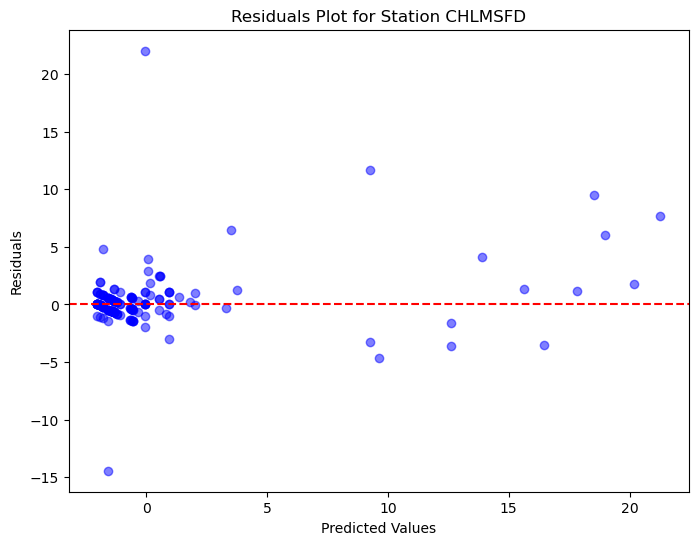

Metrics for station CHLMSFD:
Mean Absolute Error: 1.1869662921348314
Mean Squared Error: 7.274139325842696
R-squared Score: 0.7796634151937653
Best Parameters: {'algorithm': 'auto', 'leaf_size': 20, 'metric': 'euclidean', 'n_neighbors': 25, 'p': 1, 'weights': 'uniform'}
-------------------------------
{'LIVST': KNeighborsRegressor(leaf_size=20, metric='manhattan', n_neighbors=41, p=1), 'STFD': KNeighborsRegressor(leaf_size=20, metric='euclidean', n_neighbors=31, p=1), 'SHENFLD': KNeighborsRegressor(algorithm='ball_tree', leaf_size=10, metric='euclidean',
                    n_neighbors=31, p=1), 'CHLMSFD': KNeighborsRegressor(leaf_size=20, metric='euclidean', n_neighbors=25, p=1)}
(178, 15)


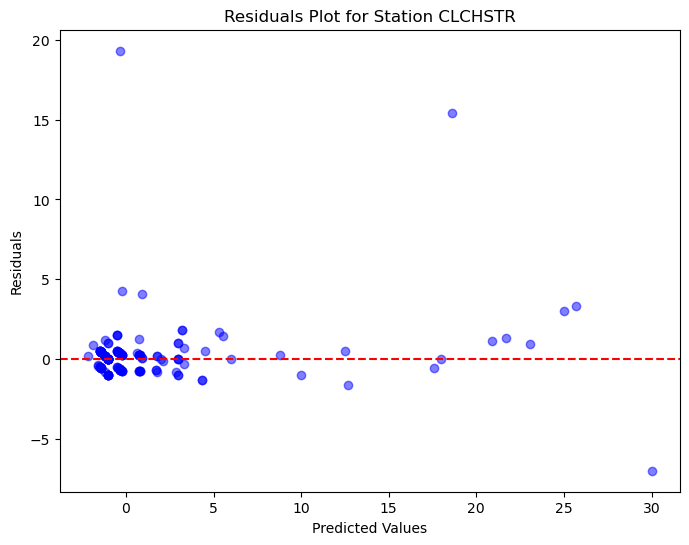

Metrics for station CLCHSTR:
Mean Absolute Error: 0.8259359796961642
Mean Squared Error: 4.4391553338934315
R-squared Score: 0.8778773899408278
Best Parameters: {'algorithm': 'brute', 'leaf_size': 10, 'metric': 'euclidean', 'n_neighbors': 25, 'p': 1, 'weights': 'distance'}
-------------------------------
{'LIVST': KNeighborsRegressor(leaf_size=20, metric='manhattan', n_neighbors=41, p=1), 'STFD': KNeighborsRegressor(leaf_size=20, metric='euclidean', n_neighbors=31, p=1), 'SHENFLD': KNeighborsRegressor(algorithm='ball_tree', leaf_size=10, metric='euclidean',
                    n_neighbors=31, p=1), 'CHLMSFD': KNeighborsRegressor(leaf_size=20, metric='euclidean', n_neighbors=25, p=1), 'CLCHSTR': KNeighborsRegressor(algorithm='brute', leaf_size=10, metric='euclidean',
                    n_neighbors=25, p=1, weights='distance')}
(178, 15)


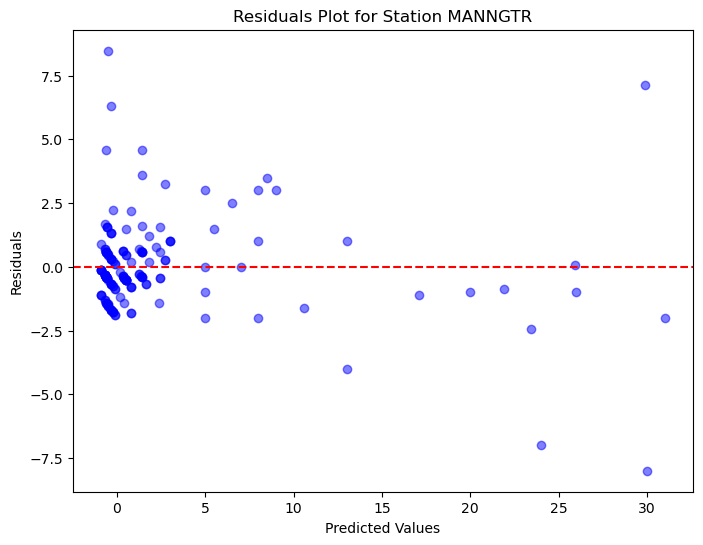

Metrics for station MANNGTR:
Mean Absolute Error: 1.1675131920872257
Mean Squared Error: 3.1884158352750065
R-squared Score: 0.9148301334139997
Best Parameters: {'algorithm': 'auto', 'leaf_size': 40, 'metric': 'euclidean', 'n_neighbors': 25, 'p': 1, 'weights': 'distance'}
-------------------------------
{'LIVST': KNeighborsRegressor(leaf_size=20, metric='manhattan', n_neighbors=41, p=1), 'STFD': KNeighborsRegressor(leaf_size=20, metric='euclidean', n_neighbors=31, p=1), 'SHENFLD': KNeighborsRegressor(algorithm='ball_tree', leaf_size=10, metric='euclidean',
                    n_neighbors=31, p=1), 'CHLMSFD': KNeighborsRegressor(leaf_size=20, metric='euclidean', n_neighbors=25, p=1), 'CLCHSTR': KNeighborsRegressor(algorithm='brute', leaf_size=10, metric='euclidean',
                    n_neighbors=25, p=1, weights='distance'), 'MANNGTR': KNeighborsRegressor(leaf_size=40, metric='euclidean', n_neighbors=25, p=1,
                    weights='distance')}
(178, 15)


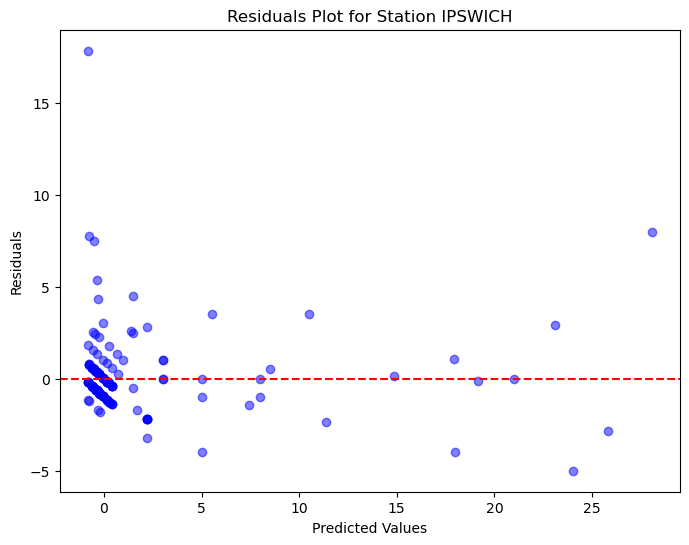

Metrics for station IPSWICH:
Mean Absolute Error: 1.1771361825901299
Mean Squared Error: 4.698583108233723
R-squared Score: 0.8428821935490818
Best Parameters: {'algorithm': 'brute', 'leaf_size': 10, 'metric': 'euclidean', 'n_neighbors': 25, 'p': 1, 'weights': 'distance'}
-------------------------------
{'LIVST': KNeighborsRegressor(leaf_size=20, metric='manhattan', n_neighbors=41, p=1), 'STFD': KNeighborsRegressor(leaf_size=20, metric='euclidean', n_neighbors=31, p=1), 'SHENFLD': KNeighborsRegressor(algorithm='ball_tree', leaf_size=10, metric='euclidean',
                    n_neighbors=31, p=1), 'CHLMSFD': KNeighborsRegressor(leaf_size=20, metric='euclidean', n_neighbors=25, p=1), 'CLCHSTR': KNeighborsRegressor(algorithm='brute', leaf_size=10, metric='euclidean',
                    n_neighbors=25, p=1, weights='distance'), 'MANNGTR': KNeighborsRegressor(leaf_size=40, metric='euclidean', n_neighbors=25, p=1,
                    weights='distance'), 'IPSWICH': KNeighborsRegressor(algo

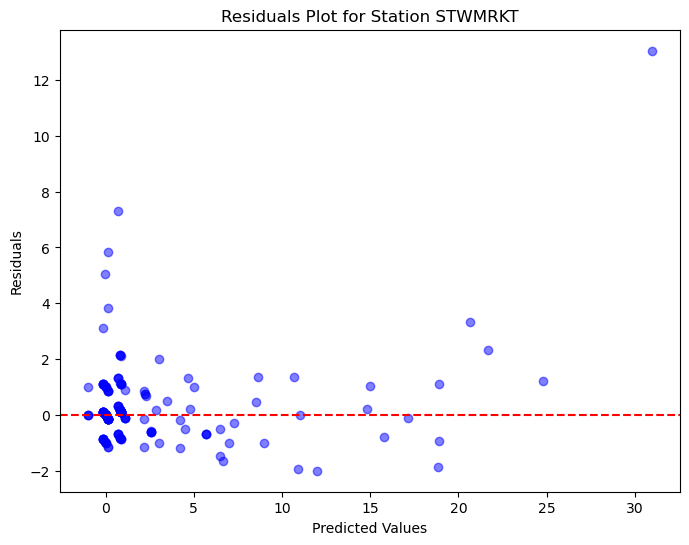

Metrics for station STWMRKT:
Mean Absolute Error: 0.8299931255228028
Mean Squared Error: 2.4594859732877303
R-squared Score: 0.9247563097121831
Best Parameters: {'algorithm': 'auto', 'leaf_size': 40, 'metric': 'euclidean', 'n_neighbors': 25, 'p': 1, 'weights': 'distance'}
-------------------------------
{'LIVST': KNeighborsRegressor(leaf_size=20, metric='manhattan', n_neighbors=41, p=1), 'STFD': KNeighborsRegressor(leaf_size=20, metric='euclidean', n_neighbors=31, p=1), 'SHENFLD': KNeighborsRegressor(algorithm='ball_tree', leaf_size=10, metric='euclidean',
                    n_neighbors=31, p=1), 'CHLMSFD': KNeighborsRegressor(leaf_size=20, metric='euclidean', n_neighbors=25, p=1), 'CLCHSTR': KNeighborsRegressor(algorithm='brute', leaf_size=10, metric='euclidean',
                    n_neighbors=25, p=1, weights='distance'), 'MANNGTR': KNeighborsRegressor(leaf_size=40, metric='euclidean', n_neighbors=25, p=1,
                    weights='distance'), 'IPSWICH': KNeighborsRegressor(algo

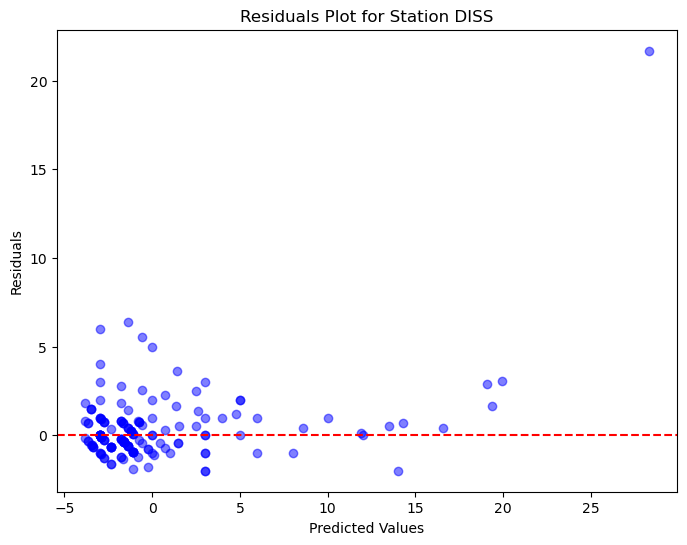

Metrics for station DISS:
Mean Absolute Error: 1.0473513496631741
Mean Squared Error: 4.5912189694623695
R-squared Score: 0.876955039578861
Best Parameters: {'algorithm': 'ball_tree', 'leaf_size': 40, 'metric': 'euclidean', 'n_neighbors': 25, 'p': 1, 'weights': 'distance'}
-------------------------------
{'LIVST': KNeighborsRegressor(leaf_size=20, metric='manhattan', n_neighbors=41, p=1), 'STFD': KNeighborsRegressor(leaf_size=20, metric='euclidean', n_neighbors=31, p=1), 'SHENFLD': KNeighborsRegressor(algorithm='ball_tree', leaf_size=10, metric='euclidean',
                    n_neighbors=31, p=1), 'CHLMSFD': KNeighborsRegressor(leaf_size=20, metric='euclidean', n_neighbors=25, p=1), 'CLCHSTR': KNeighborsRegressor(algorithm='brute', leaf_size=10, metric='euclidean',
                    n_neighbors=25, p=1, weights='distance'), 'MANNGTR': KNeighborsRegressor(leaf_size=40, metric='euclidean', n_neighbors=25, p=1,
                    weights='distance'), 'IPSWICH': KNeighborsRegressor(alg

In [22]:
X_ESSENTIAL.to_csv('hmmmmmm.csv', index=False)
print(X_ESSENTIAL[X_ESSENTIAL['STATION'] == 'LIVST'].shape)
print(X_ESSENTIAL[X_ESSENTIAL['STATION'] == 'MANNGTR'].shape)
if knn:

    # Define the parameter grid for grid search
    param_grid = {
        #'n_neighbors': [ 7, 9,11,13,15,17,25],  # Adjust the range of neighbors as needed
        'n_neighbors': [ 25,31,35,41],
        'weights': ['uniform', 'distance'],  # Adjust weight options as needed
        'p': [1, 2]  # Adjust the distance metric (1 for Manhattan, 2 for Euclidean)
    }
    param_grid = {
        'n_neighbors': [25, 31, 35, 41,51],
        'weights': ['uniform', 'distance'],  # Adjust weight options as needed
        'p': [1, 2],  # Adjust the distance metric (1 for Manhattan, 2 for Euclidean)
        'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],  # Algorithm for computing nearest neighbors
        'leaf_size': [10, 20, 30, 40],  # Leaf size passed to BallTree or KDTree
        'metric': ['mahalanobis', 'euclidean', 'manhattan']  # Distance metric to use for the tree
    }

    stations = X_ESSENTIAL['STATION'].unique()
    stations = stations.tolist()
    models_knn = {}

    for i in range(len(stations)-1):
        # Filter data for the current station
        station_data = X_ESSENTIAL[X_ESSENTIAL['STATION'] == stations[i]]
        next_station_data = X_ESSENTIAL[X_ESSENTIAL['STATION'] == stations[i+1]]

        # Set negative values in 'DIFFERENCE' column to 0
        #next_station_data['DIFFERENCE'] = next_station_data['DIFFERENCE'].clip(lower=0)

        # Select features and target
        X = station_data.drop(columns=['rid','STATION'])
        y = next_station_data['DIFFERENCE']

        # Split data into train and test sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Create KNN regressor
        knn = KNeighborsRegressor()

        # Perform grid search
        grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
        grid_search.fit(X_train, y_train)

        # Get the best model
        best_knn = grid_search.best_estimator_

        # Evaluate the best model
        y_pred = best_knn.predict(X_test)
        print(X_test.shape)
        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        plot_resids(y_test, y_pred)
        print(f"Metrics for station {stations[i]}:")
        print(f"Mean Absolute Error: {mae}")
        print(f"Mean Squared Error: {mse}")
        print(f"R-squared Score: {r2}")
        print("Best Parameters:", grid_search.best_params_)
        print("-------------------------------")

        # Save the trained model
        models_knn[stations[i]] = best_knn

        print(models_knn)



param_grid = {
    'n_neighbors': [25, 31, 35, 41],
    'weights': ['uniform', 'distance'],  # Adjust weight options as needed
    'p': [1, 2],  # Adjust the distance metric (1 for Manhattan, 2 for Euclidean)
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],  # Algorithm for computing nearest neighbors
    'leaf_size': [10, 20, 30, 40],  # Leaf size passed to BallTree or KDTree
    'metric': ['mahalanobis', 'euclidean', 'manhattan']  # Distance metric to use for the tree
}

Best Parameters: {'algorithm': 'ball_tree', 'leaf_size': 10, 'metric': 'euclidean', 'n_neighbors': 41, 'p': 1, 'weights': 'distance'}

{'LIVST': KNeighborsRegressor(algorithm='brute', leaf_size=10, metric='euclidean',
                    n_neighbors=25, p=1, weights='distance'), 'STFD': KNeighborsRegressor(algorithm='brute', leaf_size=10, metric='euclidean',
                    n_neighbors=25, p=1, weights='distance'), 'SHENFLD': KNeighborsRegressor(algorithm='brute', leaf_size=10, metric='euclidean',
                    n_neighbors=41, p=1), 'CHLMSFD': KNeighborsRegressor(algorithm='brute', leaf_size=10, metric='manhattan',
                    n_neighbors=41, p=1), 'CLCHSTR': KNeighborsRegressor(algorithm='ball_tree', leaf_size=40, metric='euclidean',
                    n_neighbors=41, p=1), 'MANNGTR': KNeighborsRegressor(algorithm='brute', leaf_size=10, metric='euclidean',
                    n_neighbors=41, p=1), 'IPSWICH': KNeighborsRegressor(algorithm='brute', leaf_size=10, metric='euclidean',
                    n_neighbors=41, p=1), 'STWMRKT': KNeighborsRegressor(algorithm='brute', leaf_size=10, metric='euclidean',
                    n_neighbors=41, p=1), 'DISS': KNeighborsRegressor(algorithm='ball_tree', leaf_size=10, metric='euclidean',
                    n_neighbors=41, p=1, weights='distance')}

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

if mlp:

    # Define the parameter grid for grid search
    param_grid = {
        'mlpregressor__hidden_layer_sizes': [(100,), (50, 50), (100, 50, 25)],
        #'mlpregressor__hidden_layer_sizes': [(100,)],
        'mlpregressor__activation': ['identity', 'relu', 'tanh'],
        'mlpregressor__alpha': [0.01],
        'mlpregressor__solver': ['adam'],
        'mlpregressor__learning_rate_init': [0.001,0.01]  # Initial learning rate
    }

    stations = X_ESSENTIAL['STATION'].unique()
    models_nn = {}

    for i in range(len(stations)-1):
        # Filter data for the current station
        station_data = X_ESSENTIAL[X_ESSENTIAL['STATION'] == stations[i]]
        next_station_data = X_ESSENTIAL[X_ESSENTIAL['STATION'] == stations[i+1]]

        # Set negative values in 'DIFFERENCE' column to 0
        #next_station_data['DIFFERENCE'] = next_station_data['DIFFERENCE'].clip(lower=0)

        # Select features and target
        X = station_data.drop(columns=['rid','STATION'])
        y = next_station_data['DIFFERENCE']

        # Split data into train and test sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Create a pipeline with preprocessing and MLPRegressor
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('mlpregressor', MLPRegressor(max_iter=1000, random_state=42))
        ])

        # Perform grid search
        grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
        grid_search.fit(X_train, y_train)

        # Get the best model
        best_model = grid_search.best_estimator_

        # Evaluate the best model
        y_pred = best_model.predict(X_test)
        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        # plot_resids(y_test, y_pred)  # You may need to define plot_resids function
        print(f"Metrics for station {stations[i]}:")
        print(f"Mean Absolute Error: {mae}")
        print(f"Mean Squared Error: {mse}")
        print(f"R-squared Score: {r2}")
        print("Best Parameters:", grid_search.best_params_)
        print("-------------------------------")

        # Save the trained model
        models_nn[stations[i]] = best_model
        print(models_nn)

In [24]:
#format:
#[late,weekend, offpeak,h1,h2,h3,h4,h5,fri,mon,sat,sun,thurs,tues,weds]
def parameterise(lateness, hour, day_of_week):
    "Encodes the input params into machine-readable format"
    def group_hours(hour_func):
        for i, (start, end) in enumerate(ranges):
            if start <= hour_func <= end:
                return f'Group_{i + 1}'
        return 'Other'
    is_weekend = 0
    is_offpeak = 0
    
    if (day_of_week == 'SAT') or(day_of_week == 'SUN'):
        is_weekend = 1
        is_offpeak = 1
    if (hour >= 9) or (hour <= 2):
        is_offpeak = 1
    ranges = [(6,9),(10, 15), (16, 19), (20, 23),(0,5)]
    group = group_hours(hour)
    
    one_hot_array = [0] * (len(ranges) )  # Initialize array with zeros
    if group != 'Other':
        group_index = int(group.split('_')[1]) - 1
        one_hot_array[group_index] = 1  # Set the corresponding index to 1
    else:
        one_hot_array[-1] = 1  # Set the last index to 1 for 'Other' group
        
    days_of_week = ['FRI','MON','SAT','SUN','THURS','TUES','WEDS']
    one_hot_day = [0] * len(days_of_week)  # Initialize array with zeros
    if day_of_week in days_of_week:
        index = days_of_week.index(day_of_week)
        one_hot_day[index] = 1  # Set the corresponding index to 1
    output = [lateness, is_weekend, is_offpeak]
    for val in one_hot_array:
        output.append(val)
    for val in one_hot_day:
        output.append(val)
    output = np.array(output)    
    output = output.reshape(1,-1)
    return output
    
    
print(parameterise(-10,10,'SAT'))    
    

[[-10   1   1   0   1   0   0   0   0   0   1   0   0   0   0]]


param_grid = {
    'mlpregressor__hidden_layer_sizes': [(100,), (50, 50), (100, 50, 25)],
    #'mlpregressor__hidden_layer_sizes': [(100,)],
    'mlpregressor__activation': ['relu', 'softmax'],
    'mlpregressor__alpha': [0.01],
    'mlpregressor__solver': ['adam']
}

{'LIVST': Pipeline(steps=[('scaler', StandardScaler()),
                ('mlpregressor',
                 MLPRegressor(alpha=0.01, max_iter=1000, random_state=42))]), 'STFD': Pipeline(steps=[('scaler', StandardScaler()),
                ('mlpregressor',
                 MLPRegressor(alpha=0.01, max_iter=1000, random_state=42))]), 'SHENFLD': Pipeline(steps=[('scaler', StandardScaler()),
                ('mlpregressor',
                 MLPRegressor(alpha=0.01, hidden_layer_sizes=(100, 50, 25),
                              max_iter=1000, random_state=42))]), 'CHLMSFD': Pipeline(steps=[('scaler', StandardScaler()),
                ('mlpregressor',
                 MLPRegressor(alpha=0.01, hidden_layer_sizes=(50, 50),
                              max_iter=1000, random_state=42))]), 'CLCHSTR': Pipeline(steps=[('scaler', StandardScaler()),
                ('mlpregressor',
                 MLPRegressor(alpha=0.01, hidden_layer_sizes=(100, 50, 25),
                              max_iter=1000, random_state=42))]), 'MANNGTR': Pipeline(steps=[('scaler', StandardScaler()),
                ('mlpregressor',
                 MLPRegressor(alpha=0.01, max_iter=1000, random_state=42))]), 'IPSWICH': Pipeline(steps=[('scaler', StandardScaler()),
                ('mlpregressor',
                 MLPRegressor(alpha=0.01, hidden_layer_sizes=(100, 50, 25),
                              max_iter=1000, random_state=42))]), 'STWMRKT': Pipeline(steps=[('scaler', StandardScaler()),
                ('mlpregressor',
                 MLPRegressor(alpha=0.01, max_iter=1000, random_state=42))]), 'DISS': Pipeline(steps=[('scaler', StandardScaler()),
                ('mlpregressor',
                 MLPRegressor(alpha=0.01, max_iter=1000, random_state=42))])}

THE MODEL IN USE:

In [30]:
# current_station = 'STFD'  # Starting station

# stations = X_ESSENTIAL['STATION'].unique()
# stations = stations.tolist()
# starting_index = stations.index(current_station)
# #starting_index = starting_index + 1
# #parameters = np.array([600,1,1,2,2]) # lateness-weekend-offpeak-day-hour 
# parameters = np.array([20,1,1,-1.50601658,0,0,0,0,0,0,1])

# parameters = parameters.reshape(1,-1)

# next_station = stations[starting_index]
# target = 'NRCH'

# while next_station != target:  # Stop when you reach target
#     # Predict lateness at the next station
#     next_lateness = models_nn[next_station].predict(parameters)
#     parameters[0][0] = next_lateness

#     starting_index = starting_index + 1
#     next_station = stations[starting_index]
    
#     # Print the predicted lateness for the next station
#     print(f"Predicted lateness at {next_station}: ",parameters[0][0], "minutes")
    

def predict_lateness(current_station, target,lateness, hour, day, models):
    stations = ['LIVST', 'STFD', 'SHENFLD', 'CHLMSFD', 'CLCHSTR', 'MANNGTR', 'IPSWICH', 'STWMRKT', 'DISS', 'NRCH']
    starting_index = stations.index(current_station)
    #starting_index = starting_index + 1
    #parameters = np.array([600,1,1,2,2]) # lateness-weekend-offpeak-day-hour 
    parameters = parameterise(lateness, hour, day)
    print(parameters)
    next_station = stations[starting_index]
    target = 'NRCH'

    while next_station != target:  # Stop when you reach target
        # Predict lateness at the next station
        next_lateness = models[next_station].predict(parameters)
        parameters[0][0] = next_lateness

        starting_index = starting_index + 1
        next_station = stations[starting_index]

        # Print the predicted lateness for the next station
        print(f"Predicted lateness at {next_station}: ",parameters[0][0], "minutes")
target = 'NRCH'
current_station = 'STFD' 
predict_lateness(current_station, target, 60,8,'SAT', models_knn)

[[60  1  1  1  0  0  0  0  0  0  1  0  0  0  0]]
Predicted lateness at SHENFLD:  8 minutes
Predicted lateness at CHLMSFD:  9 minutes
Predicted lateness at CLCHSTR:  12 minutes
Predicted lateness at MANNGTR:  14 minutes
Predicted lateness at IPSWICH:  14 minutes
Predicted lateness at STWMRKT:  11 minutes
Predicted lateness at DISS:  13 minutes
Predicted lateness at NRCH:  9 minutes


Possibly add the first train that is late - also figure out what 'associated journey means' 

1. First station deviation from Departure time, i.e.
7. Associated Journey
8. Associated Journey Deviation from Departure
9. Associated Journey First Stop
10. Associated Journey Second Stop

In [ ]:
X_ESSENTIAL.to_csv('tester5.csv', index=False)

In [35]:
def predict_lateness(current_station, target,lateness, hour, day, models):
    stations = ['LIVST', 'STFD', 'SHENFLD', 'CHLMSFD', 'CLCHSTR', 'MANNGTR', 'IPSWICH', 'STWMRKT', 'DISS', 'NRCH']
    starting_index = stations.index(current_station)
    #starting_index = starting_index + 1
    #parameters = np.array([600,1,1,2,2]) # lateness-weekend-offpeak-day-hour 
    parameters = parameterise(lateness, hour, day)

    next_station = stations[starting_index]
    target = 'NRCH'

    while next_station != target:  # Stop when you reach target
        # Predict lateness at the next station
        next_lateness = models[next_station].predict(parameters)
        parameters[0][0] = next_lateness

        starting_index = starting_index + 1
        next_station = stations[starting_index]

        # Print the predicted lateness for the next station
        print(f"Predicted lateness at {next_station}: ",parameters[0][0], "minutes")
target = 'NRCH'
current_station = 'LIVST' 
predict_lateness(current_station, target, 15,8,'SUN', models_knn)

Predicted lateness at STFD:  0 minutes
Predicted lateness at SHENFLD:  0 minutes
Predicted lateness at CHLMSFD:  2 minutes
Predicted lateness at CLCHSTR:  0 minutes
Predicted lateness at MANNGTR:  0 minutes
Predicted lateness at IPSWICH:  0 minutes
Predicted lateness at STWMRKT:  0 minutes
Predicted lateness at DISS:  0 minutes
Predicted lateness at NRCH:  -2 minutes


In [31]:
def save_models(model_dict):
    for station_name, model in model_dict.items():
        with open(f'{station_name}_model_knn_not_imputed.pkl', 'wb') as f:
            pickle.dump(model, f)


Process data for neural network